In [1]:


from itertools import product
from datasets import load_dataset,load_from_disk
import config
import os
import pandas as pd
import util
import torch
import plotting


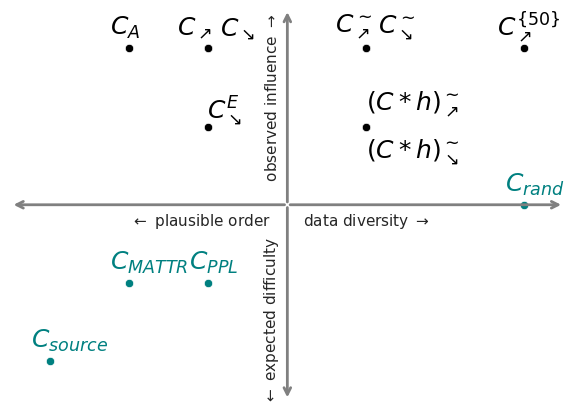

In [327]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import os  # Make sure os is imported

data = {
    "source_difficulty.pt": (-3,-2),
    "mattr_increasing.pt": (-2,-1),
    "perplexity_increasing.pt": (-1,-1),
    "_influence_epoch_repetition.pt": (-1,1),
    "_influence_decr_cp_dirac.pt": (-1,2),
    "_influence_incr_cp_dirac.pt": (-1,2),
    "_influence_decr_bins_lognorm.pt": (1,1),
    "_influence_decr_bins_dirac.pt": (1,2),
    "_influence_incr_bins_lognorm.pt": (1,1),
    "_influence_incr_bins_dirac.pt": (1,2),
    "_influence_top_50_cp_shuffled.pt": (3,2),
    "_influence_tracin_sandwich.pt": (-2,2),
    "random.pt": (3,0),
}

df = pd.DataFrame(data).T.rename({0: "x", 1: "y"}, axis=1)

label_offsets = {
    "_influence_epoch_repetition.pt": (-0.02,0),
    "_influence_decr_cp_dirac.pt": (0.15,0.1),
    "_influence_incr_cp_dirac.pt": (-0.4,0.1),
    "_influence_top_50_cp_shuffled.pt": (-0.350,0.050),
    "_influence_incr_bins_lognorm.pt": (-0,0.1),
    "_influence_decr_bins_lognorm.pt": (-0,-0.5),
    "_influence_incr_bins_dirac.pt": (-0.4,0.1),
    "_influence_decr_bins_dirac.pt": (0.15,0.1)
}


color_map = {
   
    # "_influence_decr_cp_dirac.pt": "gray",
    # "_influence_incr_cp_dirac.pt": "gray",
    # "_influence_decr_bins_dirac.pt": "gray",
    # "_influence_incr_bins_dirac.pt": "gray",


 
}
color_map = color_map | {key:"teal" for key in config.baseline_curricula}

sns.set_style("whitegrid", {'axes.grid': False})
plt.figure(figsize=(6, 4.5))

ax = plt.gca()


for label, row in df.iterrows():
    color = color_map.get(label, "black")  
    sns.scatterplot(x=[row["x"]], y=[row["y"]], color=color, ax=ax)


for label, row in df.iterrows():
    renamed = util.rename(label)
    offset_x, offset_y = label_offsets.get(label, (-0.25, 0.1))  # Default offset if none specified
    color = color_map.get(label, "black")  # Get the color for this label
    plt.text(row["x"] + offset_x, row["y"] + offset_y, renamed, fontsize=18, ha='left', va='bottom', color=color)


plt.text(-1.1, -0.2, "$\leftarrow$ plausible order", fontsize=11, ha='center', va='center', rotation=0)
plt.text(1, -0.2, "data diversity $\\rightarrow$", fontsize=11, ha='center', va='center', rotation=0)
plt.text(-0.2, 1.35, " observed influence $\\rightarrow$", fontsize=11, ha='center', va='center', rotation=90)
plt.text(-0.2, -1.5, " $\leftarrow$ expected difficulty", fontsize=11, ha='center', va='center', rotation=90)

# Set spine and arrow properties
ax.spines['left'].set_linewidth(2)
ax.spines['bottom'].set_linewidth(2)

arrowprops = dict(facecolor='black', edgecolor='black', linewidth=2)
ax.annotate('', xy=(3.5, 0), xytext=(0, 0), arrowprops=dict(arrowstyle="->", color='gray', lw=2))
ax.annotate('', xy=(0, 2.5), xytext=(0, 0), arrowprops=dict(arrowstyle="->", color='gray', lw=2))
ax.annotate('', xy=(0, -2.5), xytext=(0, 0), arrowprops=dict(arrowstyle="->", color='gray', lw=2))
ax.annotate('', xy=(-3.5, 0), xytext=(0, 0), arrowprops=dict(arrowstyle="->", color='gray', lw=2))

# Ticks + scale
plt.xticks(range(-5, 6))
plt.yticks(range(-2, 11))

plt.xlim(-3.51, 3.51)
ax.set_ylabel('')
ax.set_xlabel('')
plt.ylim(-2.5, 2.5)
ax.set_xticklabels([])
ax.set_yticklabels([])
for spine in ax.spines.values():
    spine.set_visible(False)
plt.tight_layout()

save_path = os.path.join("./autogenerated_figures", "curricula_compass.pdf")
os.makedirs(os.path.dirname(save_path), exist_ok=True)
plt.savefig(save_path, dpi=600, bbox_inches='tight')
plt.show()


In [2]:

# import os
# import pandas as pd
# import torch
# from itertools import product
# from tqdm import tqdm
# from concurrent.futures import ThreadPoolExecutor, as_completed
# import threading

# stats = []
# stats_lock = threading.Lock()

# all_combinations = [
#     (d + "_" + t + "_random", d, t, c)
#     for d, t, c in product(config.datasets, config.model_types, config.baseline_curricula)
# ]

# def process_combination(combination):
#     model_name, dataset_name, model_type, curriculum_name = combination
#     local_stats = []
#     try:
#         influence_output_dir = os.path.join(
#             "./influence_mean_normalized",
#             os.path.basename(model_name),
#             "_".join([(os.path.basename(dataset_name) + "_" + "train[0%:100%]")] * 2),
#         )

#         dataset = load_dataset(dataset_name)["train"]
#         curriculum = util.get_curriculum(dataset_name, curriculum_name)

#         # Load data into DataFrame
#         df = pd.DataFrame({
#             int(result_checkpoint.replace("checkpoint-", "")): torch.load(
#                 os.path.join(influence_output_dir, result_checkpoint),
#                 weights_only=True,
#                 map_location="cpu"
#             ).numpy().flatten()
#             for result_checkpoint in os.listdir(influence_output_dir)
#         })
#         df = df.reindex(sorted(df.columns), axis=1)
#         df["total"] = df.sum(axis=1)
#         df[["text", "source", "stage"]] = dataset.to_pandas()
#         df["document_lenght"] = df["text"].str.split().str.len()

#         def add_stat(counts, words, curriculum_label, epoch):
#             c = pd.DataFrame(counts, columns=["counts"]).join(words)
#             c["model_name"] = model_name
#             c["dataset_name"] = dataset_name
#             c["model_type"] = model_type
#             c["curriculum_name"] = curriculum_label
#             c["epoch"] = epoch
#             local_stats.append(c)

#         for i in range(len(curriculum)):
#             counts_random = df.iloc[curriculum[i]].groupby("stage").size()
#             words_random = df.iloc[curriculum[i]].groupby("stage")["document_lenght"].sum()
#             add_stat(counts_random, words_random, curriculum_name, i)

#             for influence_curriculum_name in config.influence_curricula:
#                 full_curriculum_name = model_type + influence_curriculum_name
#                 influence_curriculum = util.get_curriculum(dataset_name, full_curriculum_name)

#                 counts_influence_curriculum = df.iloc[influence_curriculum[i]].groupby("stage").size()
#                 words_influence_curriculum = df.iloc[influence_curriculum[i]].groupby("stage")["document_lenght"].sum()
#                 add_stat(counts_influence_curriculum, words_influence_curriculum, full_curriculum_name, i)

#     except Exception as e:
#         print(f"Skipping {model_name}, {dataset_name}, {model_type}, {curriculum_name}")
#         print("Reason:", str(e))

#     with stats_lock:
#         stats.extend(local_stats)

# with ThreadPoolExecutor(max_workers=32) as executor:
#     futures = [executor.submit(process_combination, c) for c in all_combinations]
#     for _ in tqdm(as_completed(futures), total=len(futures), desc="Processing"):
#         pass


# stats_df = pd.concat(stats).reset_index()
# import matplotlib.pyplot as plt
# import pandas as pd
# import seaborn as sns
# import util
# from sklearn.metrics.pairwise import cosine_similarity


# def plot_proportions(model_type, value_column="document_lenght", skip_redundant = True):
#     save_path = os.path.join("./autogenerated_figures", "source_proportions",value_column,f"{model_type}.pdf")

#     ylabel_map = {
#         "counts": "Proportion (docs)",
#         "document_lenght": "Proportion (words)"
#     }


#     norm_df = stats_df[stats_df["model_type"] == model_type].copy()

#     datasets = norm_df['dataset_name'].unique()
#     stages = sorted(norm_df['stage'].unique())
#     left_group = ['random.pt']

#     norm_df['curriculum_group'] = norm_df['curriculum_name'].apply(
#         lambda x: 'left' if x in left_group else 'right'
#     )

#     fig, axes = plt.subplots(
#         len(datasets), 2,
#         figsize=(6, 5),
#         sharey=True,
#         gridspec_kw={'width_ratios': [1.2, len(norm_df[norm_df["curriculum_group"] != "left"]["curriculum_name"].unique())]}
#     )

#     palette = sns.color_palette("Set2")

#     if len(datasets) == 1:
#         axes = [axes]


#     for row_idx, dataset in enumerate(datasets):
#         axes[row_idx][1].set_title(util.rename_dataset(dataset), loc='left', fontsize=13, pad=2,fontweight='bold')

#         random_df = None

        
#         data = norm_df[norm_df['dataset_name'] == dataset]

#         for col_idx, group in enumerate(['left', 'right']):
#             ax = axes[row_idx][col_idx]
#             group_data = data[data['curriculum_group'] == group]

#             pivot_df = group_data.pivot_table(
#                 index=['curriculum_name', 'epoch'],
#                 columns='stage',
#                 values=value_column,
#                 fill_value=0
#             )

#             try:
#                 random_df = pivot_df.loc["random.pt"]
#             except:
#                 pass


#             pivot_df = pivot_df.apply(lambda row: row / row.sum(), axis=1)
#             if skip_redundant and "random.pt" not in pivot_df.index.get_level_values(0):
            
#                 for c in pivot_df.index.get_level_values(0).unique():
            
                    
            
#                     if c != "random.pt":
#                         pivot_vector = pivot_df.loc[c].values.reshape(1, -1)
#                         random_vector = random_df.values.reshape(1, -1)
#                         cos_sim = cosine_similarity(pivot_vector, random_vector)[0][0]

#                         if cos_sim  > 0.999:
            
#                             pivot_df = pivot_df.drop(labels=c, level=0, axis=0)
                            


#             bottom = pd.Series([0] * len(pivot_df), index=pivot_df.index)
#             for ii, stage in enumerate(stages):
#                 if stage in pivot_df:
#                     vals = pivot_df[stage]
#                     x_positions = []
#                     padding = 1
#                     for i in range(len(pivot_df)):
#                         pad = (i // 10) * padding
#                         x_positions.append(i + pad)

#                     ax.bar(x_positions, vals, bottom=bottom, label=stage, width=1.0, color=palette[ii])
#                     bottom += vals

#             if col_idx == 0:
#                 ax.set_ylabel(ylabel_map[value_column])
#             else:
#                 ax.set_ylabel("")
#                 ax.tick_params(labelleft=False)
#             ax.set_ylim(0, 1)

#             n_curricula = len(pivot_df.index.get_level_values(0).unique())
#             print(n_curricula)
#             ax.set_xticks([x + i * 11 for i in range(n_curricula) for x in [5]])
#             rename_ = lambda x : util.rename(x) if x != "random.pt" else "all other"

#             ax.set_xticklabels([rename_(pivot_df.iloc[i*10].name[0]) for i in range(n_curricula)], rotation=0)
            
        
#         a = axes[row_idx][1]
#         handles, labels = ax.get_legend_handles_labels()
#         unique_labels = []
#         unique_handles = []
#         for handle, label in zip(handles, labels):
#             if label not in unique_labels:
#                 unique_labels.append(label)
#                 unique_handles.append(handle)
#         sorted_labels_handles = sorted(zip(unique_labels, unique_handles))
#         sorted_labels, sorted_handles = zip(*sorted_labels_handles)

#         a.legend(
#                 handles=unique_handles,
#                 labels=unique_labels,
#                 bbox_to_anchor=(1.00, 0.5),
#                 loc='center left',
#                 ncol=1,
#                 fontsize=9,
#                 frameon=False
#             )
        
#     axes[-1][1].set_xlabel(f"time $\\rightarrow$")


#     plt.tight_layout()
#     plt.rcParams.update({
#         "text.usetex": False,         
#     })
#     os.makedirs(os.path.dirname(save_path),exist_ok=True)
#     plt.savefig(save_path, dpi=600,bbox_inches='tight') 
#     plt.show()
    
# from itertools import product

# for model_type, value_column in product(config.model_types, ["counts", "document_lenght"]):
#     print(model_type, value_column)
#     plot_proportions(model_type, value_column,skip_redundant=True)

In [ ]:
from scipy.stats import power_divergence

import config
from itertools import product


In [ ]:
import config

In [ ]:
import os
import pandas as pd
import torch
from itertools import product
from tqdm import tqdm
from concurrent.futures import ThreadPoolExecutor, ProcessPoolExecutor, as_completed
import threading
from multiprocessing import Manager
from scipy.stats import chisquare

stats_lock = threading.Lock()

# Use Manager to create shared cache and stats list
manager = Manager()
dataset_cache = manager.dict()
df_cache = manager.dict()
stats = manager.list()  # Shared list to store stats from all processes

def get_cached_dataset(dataset_name):
    if dataset_name not in dataset_cache:
        print(f"[Dataset] Loading: {dataset_name}")
        dataset_cache[dataset_name] = load_dataset(dataset_name)["train"].select_columns("stage")
    return dataset_cache[dataset_name]

def get_prepared_df(dataset_name, model_type):
    cache_key = (dataset_name, model_type)

    if cache_key not in df_cache:
        print(f"[DataFrame] Preparing for: {dataset_name} / {model_type}")
        
        dataset = get_cached_dataset(dataset_name)
        model_name = dataset_name + "_" + model_type + "_random"
        
        influence_output_dir = os.path.join(
            "./influence_mean_normalized",
            os.path.basename(model_name),
            "_".join([(os.path.basename(dataset_name) + "_" + "train[0%:100%]")] * 2),
        )
        
        df = pd.DataFrame({
            int(result_checkpoint.replace("checkpoint-", "")): torch.load(
                os.path.join(influence_output_dir, result_checkpoint),
                weights_only=True,
                map_location="cpu"
            ).numpy().flatten()
            for result_checkpoint in os.listdir(influence_output_dir)
        })

        df = df.reindex(sorted(df.columns), axis=1)
        df["stage"] = dataset.to_pandas()

        df_cache[cache_key] = df
        print(f"[DataFrame] Cached for: {dataset_name} / {model_type}")
    return df_cache[cache_key]

# Generate combinations
all_combinations = []

for model_type in config.model_types: 
    curricula = [model_type + c for c in config.influence_curricula] + config.baseline_curricula
    for a, b in product(curricula, curricula):
        for dataset in config.datasets[0:1]:
            all_combinations.append((dataset, model_type, a, b))
print(all_combinations)
def process_combination(combination):
    dataset_name, model_type, curriculum_a_name, curriculum_b_name = combination
    local_stats = []

    try:
        df = get_prepared_df(dataset_name, model_type)

        epsilon = 1e-100
        bins = 100

        curriculum_a = util.get_curriculum(dataset_name, curriculum_a_name)
        curriculum_b = util.get_curriculum(dataset_name, curriculum_b_name)

        examples_a = df.iloc[torch.cat(curriculum_a).flatten()]
        examples_b = df.iloc[torch.cat(curriculum_b).flatten()]

        all_stages = examples_a["stage"].unique()

        max_len = min(len(examples_a), len(examples_b))
        bin_size = max_len // bins

        chunks_to_compare = [
            (examples_a["stage"][i:i+bin_size], examples_b["stage"][i:i+bin_size])
            for i in range(0, max_len, bin_size) if i + bin_size < max_len
        ]

        local_stats.extend([
            (
                idx, curriculum_a_name, curriculum_b_name, dataset_name,
                model_type, len(a), len(b),
                chisquare(
                    f_obs=a.value_counts().reindex(all_stages, fill_value=epsilon),
                    f_exp=b.value_counts().reindex(all_stages, fill_value=epsilon),
                    ddof=0,
                ).statistic
            )
            for idx, (a, b) in enumerate(chunks_to_compare)
        ])

    except Exception as e:
        print(f"[Error] Skipping: {dataset_name}, {model_type}, {curriculum_a_name}, {curriculum_b_name}")
        print("Reason:", str(e))
  
    # Append local stats to the shared stats list safely
    with stats_lock:
        stats.extend(local_stats)

# Prepare interleaved batches
import random
from itertools import chain, zip_longest
from collections import defaultdict


first_batch = all_combinations[:3]
remaining_batch = all_combinations[3:]

# Use ThreadPoolExecutor for the first batch
with ThreadPoolExecutor(max_workers=3) as executor:
    futures = [executor.submit(process_combination, c) for c in first_batch]
    for _ in tqdm(as_completed(futures), total=len(futures), desc="Processing (3 workers)") :
        pass
print(stats)

print(len(stats))
with ProcessPoolExecutor(max_workers=64) as executor:
    futures = [executor.submit(process_combination, c) for c in remaining_batch]
    for _ in tqdm(as_completed(futures), total=len(futures), desc="Processing (64 workers)") :
        pass
print(len(stats))
stats_df = pd.DataFrame(list(stats),columns=["chunk","curriculum_a", "curriculum_b","dataset", "model_type", "chunk_size_a", "chunk_size_b", "power_divergence_stat"])





NameError: name 'config' is not defined

In [ ]:
stats_df

,chunk,curriculum_a,curriculum_b,dataset,model_type,chunk_size_a,chunk_size_b,power_divergence_stat
0,0,llama_influence_epoch_repetition.pt,llama_influence_incr_bins_dirac.pt,loris3/babylm_2024_10m_curriculum,llama,117901,117901,2.029912e+06
1,1,llama_influence_epoch_repetition.pt,llama_influence_incr_bins_dirac.pt,loris3/babylm_2024_10m_curriculum,llama,117901,117901,2.763062e+06
2,2,llama_influence_epoch_repetition.pt,llama_influence_incr_bins_dirac.pt,loris3/babylm_2024_10m_curriculum,llama,117901,117901,3.415563e+06
3,3,llama_influence_epoch_repetition.pt,llama_influence_incr_bins_dirac.pt,loris3/babylm_2024_10m_curriculum,llama,117901,117901,2.521295e+06
4,4,llama_influence_epoch_repetition.pt,llama_influence_incr_bins_dirac.pt,loris3/babylm_2024_10m_curriculum,llama,117901,117901,1.127342e+06
...,...,...,...,...,...,...,...,...
795,95,llama_influence_epoch_repetition.pt,llama_influence_decr_cp_dirac.pt,loris3/babylm_2024_10m_curriculum,llama,117901,117901,8.280151e+04
796,96,llama_influence_epoch_repetition.pt,llama_influence_decr_cp_dirac.pt,loris3/babylm_2024_10m_curriculum,llama,117901,117901,2.362842e+05
797,97,llama_influence_epoch_repetition.pt,llama_influence_decr_cp_dirac.pt,loris3/babylm_2024_10m_curriculum,llama,117901,117901,4.434524e+05
798,98,llama_influence_epoch_repetition.pt,llama_influence_decr_cp_dirac.pt,loris3/babylm_2024_10m_curriculum,llama,117901,117901,5.332987e+05


In [ ]:
stats_df = stats_df[stats_df["curriculum_b"] != "source_difficulty.pt"]

In [ ]:
stats_df

,chunk,curriculum_a,curriculum_b,dataset,model_type,chunk_size_a,chunk_size_b,power_divergence_stat
0,0,llama_influence_epoch_repetition.pt,llama_influence_incr_bins_dirac.pt,loris3/babylm_2024_10m_curriculum,llama,117901,117901,2.029912e+06
1,1,llama_influence_epoch_repetition.pt,llama_influence_incr_bins_dirac.pt,loris3/babylm_2024_10m_curriculum,llama,117901,117901,2.763062e+06
2,2,llama_influence_epoch_repetition.pt,llama_influence_incr_bins_dirac.pt,loris3/babylm_2024_10m_curriculum,llama,117901,117901,3.415563e+06
3,3,llama_influence_epoch_repetition.pt,llama_influence_incr_bins_dirac.pt,loris3/babylm_2024_10m_curriculum,llama,117901,117901,2.521295e+06
4,4,llama_influence_epoch_repetition.pt,llama_influence_incr_bins_dirac.pt,loris3/babylm_2024_10m_curriculum,llama,117901,117901,1.127342e+06
...,...,...,...,...,...,...,...,...
795,95,llama_influence_epoch_repetition.pt,llama_influence_decr_cp_dirac.pt,loris3/babylm_2024_10m_curriculum,llama,117901,117901,8.280151e+04
796,96,llama_influence_epoch_repetition.pt,llama_influence_decr_cp_dirac.pt,loris3/babylm_2024_10m_curriculum,llama,117901,117901,2.362842e+05
797,97,llama_influence_epoch_repetition.pt,llama_influence_decr_cp_dirac.pt,loris3/babylm_2024_10m_curriculum,llama,117901,117901,4.434524e+05
798,98,llama_influence_epoch_repetition.pt,llama_influence_decr_cp_dirac.pt,loris3/babylm_2024_10m_curriculum,llama,117901,117901,5.332987e+05


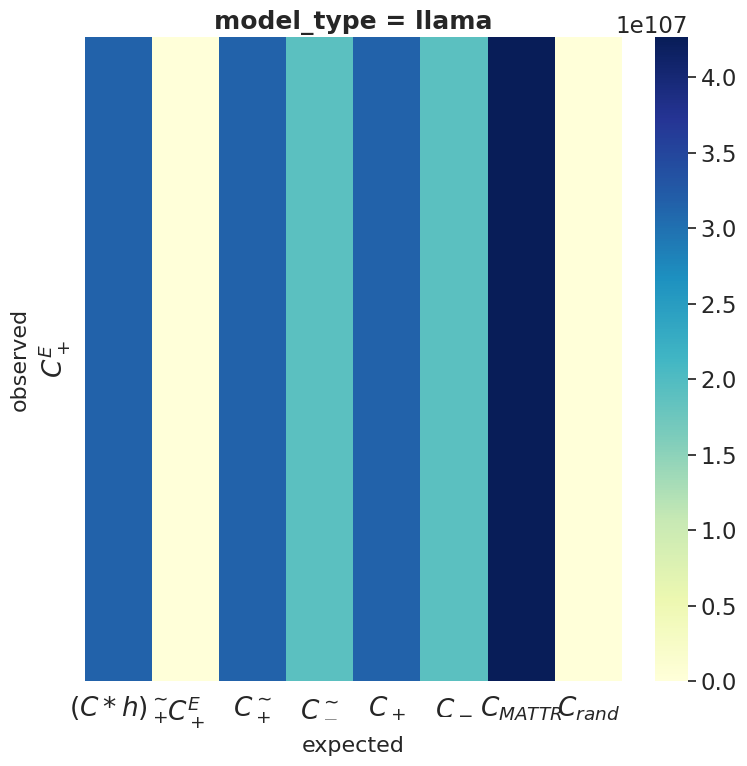

In [ ]:
# import seaborn as sns
# import matplotlib.pyplot as plt
# import numpy as np

# # Assuming stats_df is your data frame, you can calculate the std for the 'power_divergence_stat' column
# std_dev = stats_df['power_divergence_stat'].std()

# sns.set_context("talk")
# sns.set(font_scale=1.5)

# g = sns.FacetGrid(stats_df, row="model_type", height=8, sharex=False)

# def plot_heatmap(data, **kwargs):
#     pivot_df = data.pivot_table(index="curriculum_a", 
#                                 columns="curriculum_b", 
#                                 values="power_divergence_stat", 
#                                 aggfunc='mean')
#     pivot_df = pivot_df.fillna(float('nan'))
#     pivot_df = pivot_df.rename(index=util.rename, columns=util.rename)
#     pivot_df = pivot_df.sort_index(axis=0).sort_index(axis=1)
    
#     # Set vmax to 3 standard deviations


#     sns.heatmap(pivot_df, annot=False, cmap="YlGnBu", fmt=".2f", cbar=True, robust=True, **kwargs)

# g.map_dataframe(plot_heatmap)
# g.set_titles(col_template="{col_name}", fontsize=16, fontweight="bold")
# g.set_axis_labels("expected", "observed", fontsize=16)

# for ax in g.axes.flat:
#     ax.tick_params(axis='both', which='major', labelsize=19)

# plt.tight_layout()
# plt.savefig(os.path.join("./autogenerated_figures", "source_distribution_heatmap_both.pdf"), dpi=600, bbox_inches='tight')

# plt.show()


In [ ]:
stats_df["chunk_size_a"].describe()

count       800.000000
mean     124614.000000
std       17772.039549
min      117901.000000
25%      117901.000000
50%      117901.000000
75%      117901.000000
max      171605.000000
Name: chunk_size_a, dtype: float64

curriculum_a,llama_influence_epoch_repetition.pt
curriculum_b,
llama_influence_decr_bins_dirac.pt,1.914114e+107
llama_influence_decr_cp_dirac.pt,1.914114e+107
llama_influence_epoch_repetition.pt,0.000000e+00
llama_influence_incr_bins_dirac.pt,3.149533e+107
llama_influence_incr_bins_lognorm.pt,3.149533e+107
llama_influence_incr_cp_dirac.pt,3.149533e+107
mattr_increasing.pt,4.446368e+107
random.pt,1.147336e+05


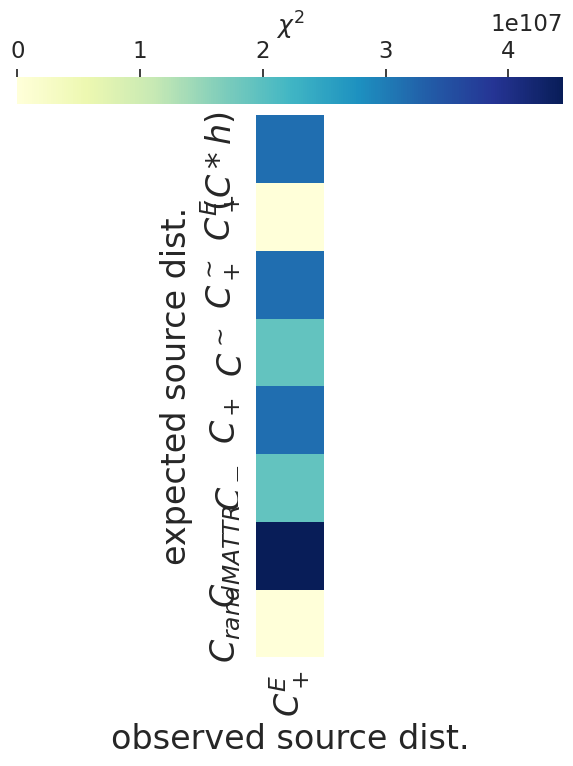

In [ ]:
power_divergence([16, 18, 16, 14, 12, 12], f_exp=[16, 16, 16, 16, 16, 8])

Power_divergenceResult(statistic=np.float64(3.5), pvalue=np.float64(0.6233876277495822))

In [ ]:
power_divergence([16, 16, 16, 16, 16, 8], f_exp=[16, 18, 16, 14, 12, 12])

Power_divergenceResult(statistic=np.float64(3.1746031746031744), pvalue=np.float64(0.6730876006966301))

In [ ]:
import numpy as np

Processing:   4%|▍         | 1/24 [00:02<01:07,  2.95s/it]

Skipping loris3/stratified_10m_curriculum_roberta_random, loris3/stratified_10m_curriculum, roberta, random.pt
Reason: [Errno 2] No such file or directory: './influence_mean_normalized/stratified_10m_curriculum_roberta_random/stratified_10m_curriculum_train[0%:100%]_stratified_10m_curriculum_train[0%:100%]'
Skipping loris3/stratified_10m_curriculum_roberta_random, loris3/stratified_10m_curriculum, roberta, perplexity_increasing.pt
Reason: [Errno 2] No such file or directory: './influence_mean_normalized/stratified_10m_curriculum_roberta_random/stratified_10m_curriculum_train[0%:100%]_stratified_10m_curriculum_train[0%:100%]'
Skipping loris3/stratified_equitoken_10m_curriculum_roberta_random, loris3/stratified_equitoken_10m_curriculum, roberta, random.pt
Reason: [Errno 2] No such file or directory: './influence_mean_normalized/stratified_equitoken_10m_curriculum_roberta_random/stratified_equitoken_10m_curriculum_train[0%:100%]_stratified_equitoken_10m_curriculum_train[0%:100%]'
Skipping

Processing:  25%|██▌       | 6/24 [00:05<00:15,  1.13it/s]

Skipping loris3/stratified_equitoken_10m_curriculum_roberta_random, loris3/stratified_equitoken_10m_curriculum, roberta, mattr_increasing.pt
Reason: [Errno 2] No such file or directory: './influence_mean_normalized/stratified_equitoken_10m_curriculum_roberta_random/stratified_equitoken_10m_curriculum_train[0%:100%]_stratified_equitoken_10m_curriculum_train[0%:100%]'


Processing:  29%|██▉       | 7/24 [00:44<02:24,  8.47s/it]

Skipping loris3/stratified_10m_curriculum_roberta_random, loris3/stratified_10m_curriculum, roberta, mattr_increasing.pt
Reason: [Errno 2] No such file or directory: './influence_mean_normalized/stratified_10m_curriculum_roberta_random/stratified_10m_curriculum_train[0%:100%]_stratified_10m_curriculum_train[0%:100%]'


Processing: 100%|██████████| 24/24 [04:39<00:00, 11.66s/it]


In [ ]:
from scipy.stats import power_divergence

all_stages = examples_influence_curriculum["stage"].unique()

chunk_size = 1000
chunks_influence_curriculum = [examples_influence_curriculum.iloc[i:i + chunk_size]["stage"].value_counts().reindex(all_stages, fill_value=0) for i in range(0, len(examples_influence_curriculum), chunk_size)]
chunks_random_curriculum = [examples_random.iloc[i:i + chunk_size]["stage"].value_counts().reindex(all_stages, fill_value=0) for i in range(0, len(examples_random), chunk_size)]

NameError: name 'examples_influence_curriculum' is not defined

In [ ]:

import numpy as np
len(chunks_influence_curriculum)

NameError: name 'chunks_influence_curriculum' is not defined

llama counts
1
3
1
3
1
3


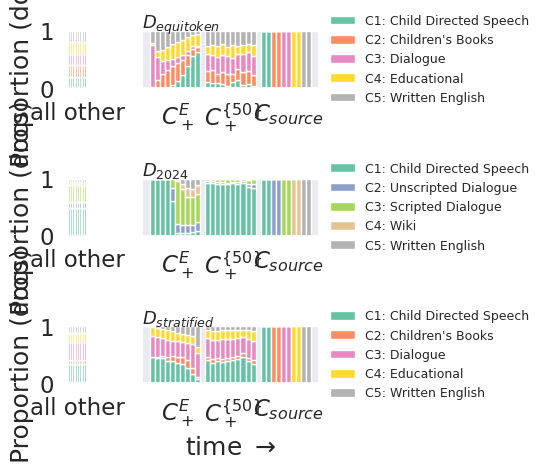

llama document_lenght
1
3
1
3
1
3


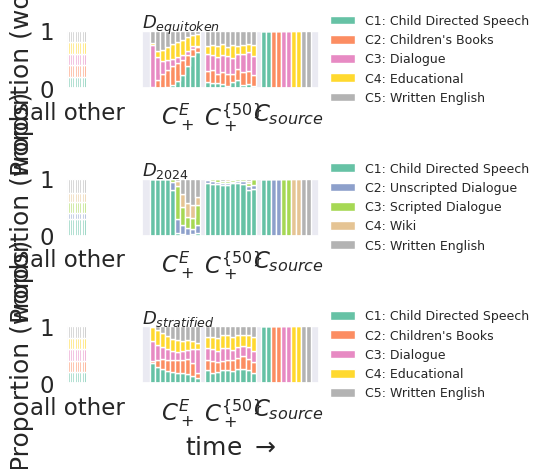

roberta counts
1
3


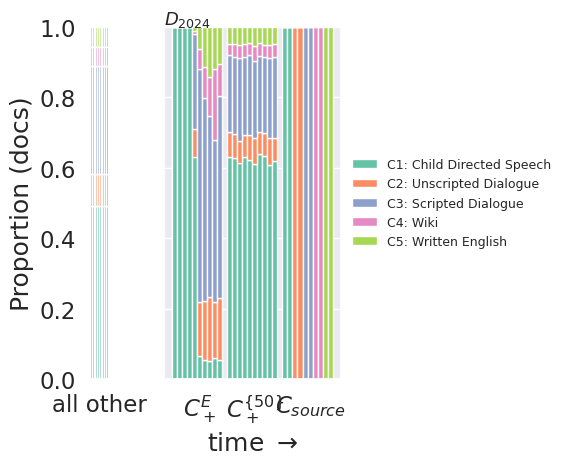

roberta document_lenght
1
3


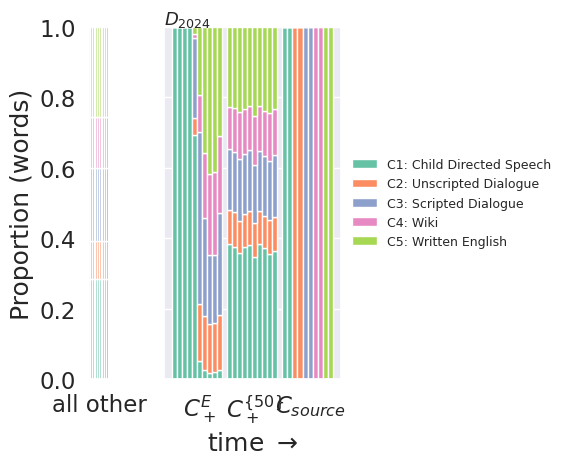

In [ ]:
asdfstats

In [ ]:
stats_df

In [ ]:
for model_name, dataset_name, model_type, curriculum_name  in [(d+"_"+t+"_"+"random", d,t,c) for d, t,c in product(config.datasets, config.model_types, ["random.pt"] )]:
    try:
        influence_output_dir = os.path.join("./influence_mean_normalized", os.path.basename(model_name), "_".join([(os.path.basename(dataset_name) +"_"+f"train[0%:100%]")]*2))
        print(influence_output_dir)
        dataset = load_dataset(dataset_name)["train"]
        curriculum = util.get_curriculum(dataset_name, curriculum_name)

        df = pd.DataFrame({int(result_checkpoint.replace("checkpoint-","")): torch.load(os.path.join(influence_output_dir,result_checkpoint),weights_only=True,map_location="cpu").numpy().flatten() for result_checkpoint in os.listdir(influence_output_dir)})
        df.sort_index(axis=1)

        df = df.reindex(sorted(df.columns, reverse=False), axis=1)
        influence_cols = df.columns
        df["total"] = df.sum(axis=1)
        df[["text", "source","stage"]] = dataset.to_pandas()
        df["document_lenght"] = df["text"].str.split().str.len()
        
        
        plotting.plot_per_token_in_order(df[influence_cols.to_list() + ["stage","document_lenght"]], curriculum_name, model_type, dataset_name, curriculum)
        plotting.plot_per_token_per_stage(df[influence_cols.to_list() + ["stage","document_lenght"]], curriculum_name, model_type, dataset_name,curriculum)



        for influence_curriculum_name in config.influence_curricula:
            print(dataset_name, influence_curriculum_name)
            influence_curriculum_name = model_type + influence_curriculum_name
            influence_curriculum = util.get_curriculum(dataset_name, influence_curriculum_name)
            plotting.plot_per_token_in_order(df[influence_cols.to_list() + ["stage","document_lenght"]], influence_curriculum_name, model_type, dataset_name,influence_curriculum)
            break
        break
    except:
        print("skipping", model_name, dataset_name, model_type, curriculum_name)

In [ ]:
counts_random = df.iloc[torch.cat(curriculum)].groupby("stage").size()
counts_random

In [ ]:

counts_influence_curriculum

In [ ]:
(counts_random - counts_influence_curriculum).plot.bar()

In [ ]:
df.groupby("stage")